In [1]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

In [2]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [3]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [4]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    
    ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [5]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

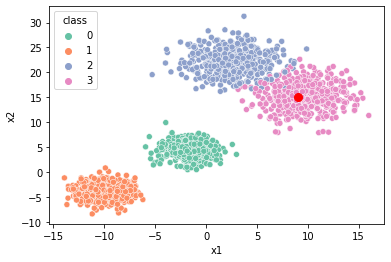

In [6]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

### LORE neigh

In [7]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

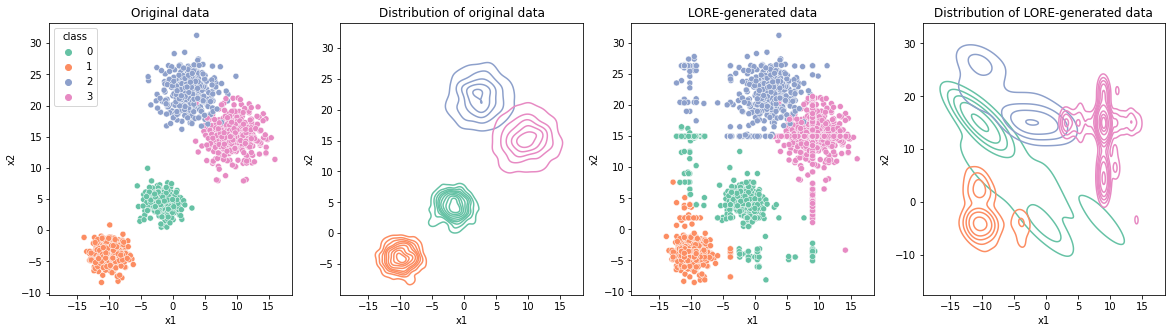

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [9]:
X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
exp_LORE, info_LORE = lore.explain(0, X_explain,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path='./EXPLAN/yadt/',
                                   sep=';', log=True, depth=10)

rule_LORE = {} 
for i,v in  exp_LORE[0][1].items():
    rule_LORE[i] = [v]


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1068\n + load time: 0.005739 secs (4.57 MiB/s, 186.09 K rows/s)\n + indexing ... done\n + total time: 0.007294 secs (3.59 MiB/s, 146.42 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\n + size: 31 depth: 8 nf: 2 time: 0.01867 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 8 nf: 2 time: 0.001317 secs\n'


In [10]:
exp_LORE

([{'class': 3},
  {'x1': '>2.440639', 'x2': '-1.146152< x2 <=19.787793'},
  [525.0, 2.6]],
 [{'x2': '<=-1.146152'}])

### EXPLAN neigh

In [11]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

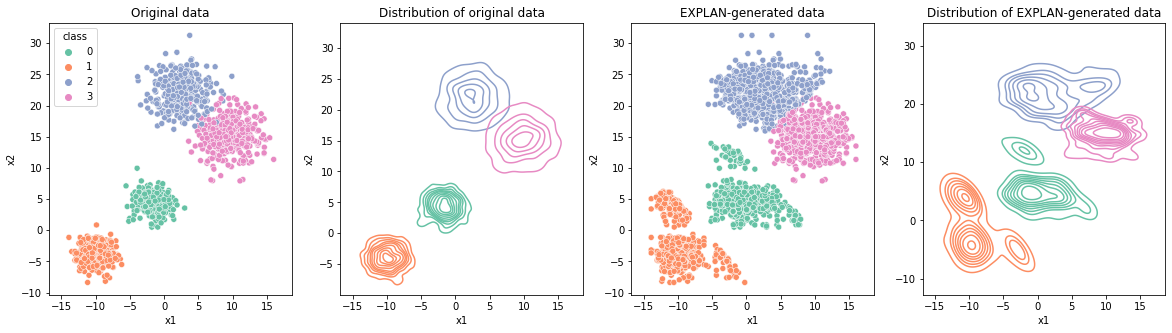

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

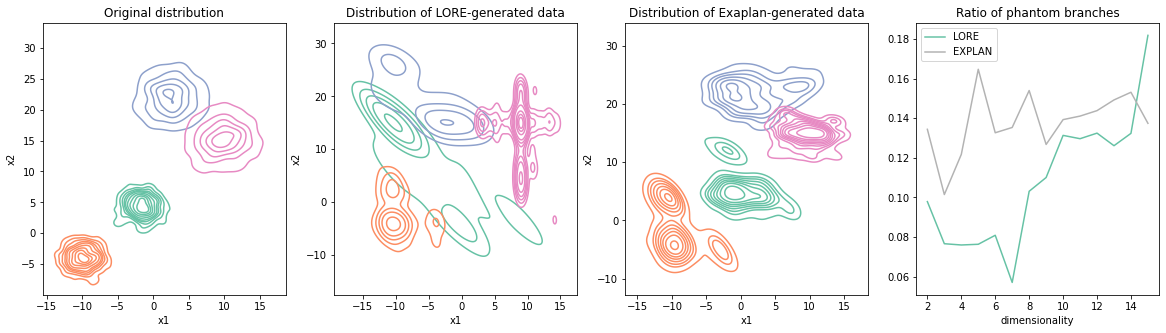

In [13]:
sdf = pd.read_csv('./results/phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

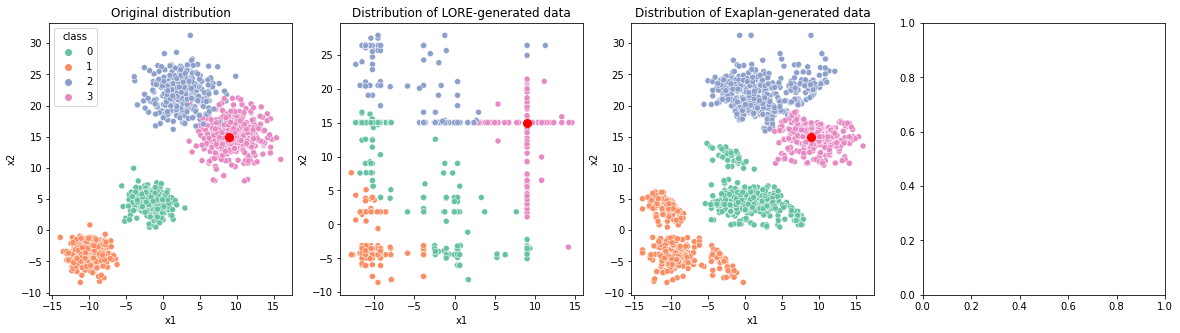

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

instance2explain = {'x1':9,'x2':15, 'class':3}
axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

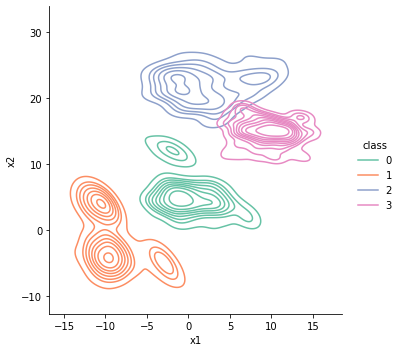

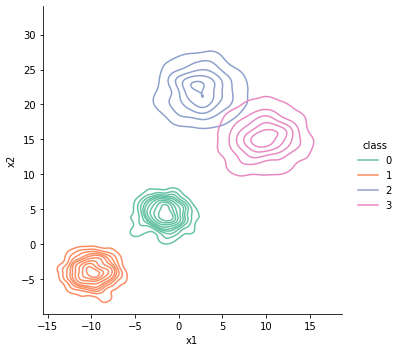

In [15]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [16]:
exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
                                               blackbox,
                                               dataset,
                                               N_samples=3000,
                                               tau=200,depth=10)
rule_EXPLAN = {} 
for i,v in  exp_EXPLAN[1].items():
    rule_EXPLAN[i] = [v]

exp_EXPLAN

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1320\n + load time: 0.005507 secs (8.91 MiB/s, 239.69 K rows/s)\n + indexing ... done\n + total time: 0.010922 secs (4.49 MiB/s, 120.85 K rows/s)\nBuilding 1 tree(s) on 1320 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 2 time: 0.004352 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 2 time: 2.8e-05 secs\n'


[{'class': 3},
 {'x2': '10.747229< x2 <=17.761678', 'x1': '>4.492216'},
 [316.0, 1.3]]

### LUX neigh

In [17]:
lux = LUX(predict_proba = blackbox.predict_proba, classifier=blackbox,neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=10)
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,
                                         representative='centroid')


(-15.400336008034298, 17.480904720359618)

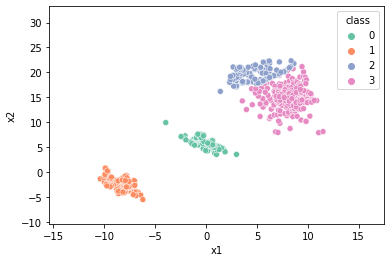

In [18]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette='Set2')
graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

In [19]:
lux.fit(train[features], train[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,prune=True,oblique=True,
                                         representative='centroid')


Exact explainer: 773it [00:10,  9.53it/s]                                                                                                                                  


In [20]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 0.8225061311261851 * x1+12.992987768880395 AND x2 >=7.766965627670288 THEN class = 3 # 1.0\n'

## New: upsample according to SHAP

In [21]:
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,
                                         representative='centroid')

In [22]:
#calculate shap values
try:
    explainer = shap.Explainer(blackbox,X_train_sample)
    if hasattr(explainer, "shap_values"):
        shap_values = explainer.shap_values(X_train_sample,check_additivity=False)
    else:
        shap_values = explainer(X_train_sample).values
        shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
    if hasattr(explainer, "expected_value"):
        expected_values = explainer.expected_value
    else:
        expected_values=[np.mean(v) for v in shap_values]
except TypeError:
    explainer = shap.Explainer(blackbox.predict_proba, X_train_sample)
    shap_values = explainer(X_train_sample).values
    shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
    expected_values=[np.mean(v) for v in shap_values]


if type(shap_values) is not list:
    shap_values = [-shap_values, shap_values]
    expected_values=[np.mean(v) for v in shap_values]
#for each of the samples, perturb it into directino fo the opposite class shap_values


In [23]:
abs(shap_values[0]).sum(0)

array([59.32576022, 75.75022665])

In [24]:
abs(shap_values[1]).sum(0)

array([73.45657991, 67.87852642])

In [25]:
abs(shap_values[2]).sum(0)

array([52.51107505, 98.19483656])

In [26]:
abs(shap_values[3]).sum(0)

array([112.42873939,  78.99673092])

In [27]:
abs_shap=  np.array([abs(sv).mean(1) for sv in shap_values])

In [28]:
abs_shap[:,0]

array([0.40401169, 0.11592305, 0.23638487, 0.21229039])

In [29]:
class_of_i2e = blackbox.predict(ei)
indexer = blackbox.predict(X_train_sample)
shapclass = []

#fit multinomial regression to shap values

for i in range(0,len(X_train_sample)):
    best_index = indexer[i]#[bi for bi in np.argpartition(abs_shap[:,i],2)[-2:] if bi != indexer[i]][0]
    #best_index = [-bi for bi in np.argpartition(abs_shap[:,i],2)[-2:] if bi != indexer[i]][0]
    #vector = np.array([[sv[i,:]]  if ie == best_index else [-sv[i,:] ] for ie,sv in enumerate(shap_values)]).sum(0)
    #shapclass.append(vector)
    shapclass.append([shap_values[best_index][i,:]])
    
shapclass=np.concatenate(shapclass)
shapcols = [c+'_shap' for c in X_train_sample.columns]
cols = [c for c in X_train_sample.columns]
shapdf = pd.DataFrame(shapclass, columns=shapcols)

In [30]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numdifftools as nd
gradsf = []
gradst = []
for cl in np.unique(indexer):
    gradcl = []
    gradstcl=[]
    for dim in range(0,X_train_sample.shape[1]):
        print(f'Clss {cl}, dim: {dim}')
        mask = indexer==cl
        xs = X_train_sample.iloc[mask,dim]
        ys = shapclass[mask,dim]
        #plt.plot(xs,ys)
        #plt.show()
        grads = np.gradient(ys,xs)
        gradstcl.append(grads)
        svr =LinearRegression()#SVR()
        svr.fit(xs.values.reshape(-1,1),ys)
        #print(svr.coef_)
        print(svr.score(xs.values.reshape(-1,1),ys))
        F=lambda x,svr=svr : svr.predict(x.reshape(1,-1))
        gradient = nd.Gradient(F)
        print(f'Gradient: {gradient([10])}')
        gradcl.append(gradient)
    gradsf.append(gradcl)
    gradst.append(gradstcl)
    

Clss 0, dim: 0
0.876022578388448
Gradient: -0.016855948086536367
Clss 0, dim: 1
0.9896412839225566
Gradient: -0.020485347300947847
Clss 1, dim: 0
0.9570363934783415
Gradient: -0.018174299188037257
Clss 1, dim: 1
0.9130498082167924
Gradient: -0.013564799092285276
Clss 2, dim: 0
0.9379366008300853
Gradient: -0.07210399177812615
Clss 2, dim: 1
0.900158139919691
Gradient: 0.0805453968663487
Clss 3, dim: 0
0.8421382773177958
Gradient: 0.048540274611011486
Clss 3, dim: 1
0.4047598575810645
Gradient: -0.023040422986199245


In [31]:
fulldf = pd.concat([X_train_sample.reset_index(drop=True), shapdf.reset_index(drop=True)],axis=1)
fulldf.index=X_train_sample.index
#fulldf = fulldf[indexer==class_of_i2e]

In [32]:
si2e = np.array(list(instance2explain.values())[:-1])
maxd=np.median(sklearn.metrics.pairwise_distances(X_train_sample, si2e.reshape(1,-1)))

In [ ]:
def perturb(x,num, alpha, gradients,cols, shapcols):
    newx = []
    last = x[cols].values
    newx.append(last)
    cl = blackbox.predict(last.reshape(1,-1))[0]
    grad = np.array([g(last[i]) for i,g in enumerate(gradients[cl])])
   # grad = np.array([g(last[i]) for i,g in enumerate(gradients[cl])])
    for _ in range(0,num):
        if blackbox.predict(last.reshape(1,-1))[0] != cl:
            break
        last =last-alpha*grad
        newx.append(last)
    return np.array(newx)
    

 
upsamples = np.concatenate(fulldf.sample(30).apply(perturb,args=(300,np.array([12,12]),gradsf,cols, shapcols),axis=1).values)

In [ ]:
fulldf[features].max()-fulldf[features].min()/5

In [ ]:
updf = pd.DataFrame(upsamples,columns=cols)


In [ ]:
fulldf[target] = blackbox.predict(fulldf[['x1','x2']])
graph_lux = sns.scatterplot(data=fulldf,x='x1', y='x2', hue='class',palette='Set2')
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
nd.Gradient()

In [ ]:
plt.plot(X_train_sample[indexer==3]['x2'].values,shapclass[indexer==3,1])

In [ ]:
plt.plot(X_train_sample[indexer==3]['x1'].values,shapclass[indexer==3,0])

In [ ]:
plt.plot(X_train_sample[indexer==2]['x2'].values,shapclass[indexer==2,1])

In [ ]:
plt.plot(X_train_sample[indexer==2]['x1'].values,shapclass[indexer==2,0])

In [ ]:
plt.plot(X_train_sample[indexer==1]['x1'].values,shapclass[indexer==1,0])

In [ ]:
plt.plot(X_train_sample[indexer==0]['x1'].values,shapclass[indexer==0,0])

In [ ]:
plt.plot(X_train_sample[indexer==0]['x1'].values,shap_values[0][indexer==0,0])

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
sns.displot(data=updf,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [ ]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?

## Example of uncertainty incorporation in LUX (explaning why model made predictio when model is uncertain of its decision)

In [ ]:
#the high precision rules and sampling around decision boundary

## Example of data generation  (true paterns visible in the data are hidden) -- NO DATA GENERATION, OR SMART GENERATION THAT DOES NOT CHANGE DISTRIBUTION

### LORE

In [ ]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [ ]:

instance2explain = {'x1':1.5,'x2':-0.5, 'class':0}
instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':0,'x2':1, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

In [ ]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

In [ ]:
sns.displot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [ ]:
# dtg = Source(tree.export_graphviz(exclf, out_file=None, feature_names=features, filled = True,max_depth=depth))
# display(SVG(dtg.pipe(format='svg')))

### Explan

In [ ]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

In [ ]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

In [ ]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

### LUX

In [ ]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

In [ ]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

In [ ]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

In [ ]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

### Lux on more complex example

In [ ]:
X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf[target] = y
features = [f for f in Xdf.columns if f not in [target]]
train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
blackbox = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

In [ ]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

In [ ]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

## Branch utilisation (phantom branches)

In [ ]:
# generate neigh with lore, explan
# fit uid3, use counterfactual code genration on real data to see how it goes
def get_covered(rule, dataset, features, categorical=None):
    if categorical is None:
        categorical = [False]*len(features)
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical))[i] == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    return covered

def coverage_rules(tree, background_train, background_eval,features):
    rules  = tree.to_dict(reduce=True)

    #filter out rules with class same as not_class
    coever_rules = []
    mingen = None
    numfan = 0
    for rule in rules:
        coever_rules.append(rule)
        #find coverage points from background
        rule['covered'] = len(get_covered(rule['rule'],background_eval, features, None))/len(get_covered(rule['rule'],background_train, features, None))
        #find candidates from background according to counterfactual_representative
        if mingen is None or mingen > rule['covered']:
            mingen=rule['covered']
        if rule['covered'] == 0:
            numfan+=1
    return coever_rules,mingen,numfan,numfan/len(rules)

summary=[]
for f in range(2,20):
    for _ in range(1,20):
        if f > 4:
            f2=int(f/2)
            f3=int(f/3)
            f1=f
        else:
            f1=f2=2
            f3=1
            
        if True:
            X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f1, #random_state=3,
                                                           n_informative=f2, n_redundant=0, n_repeated=0, n_clusters_per_class=f3,
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])
            categorical_indicator = [False]*len(features)

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))
            dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

            print('ok')

            Zdf,Z = generate_phantom_data(idx_record2explain=idx, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=True)

            print('okk')

            i2e = train.iloc[idx][features].values
            dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
            # Representative data selection step
            representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = blackbox.predict(Ndf[features])


            lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, 
                      grow_confidence_threshold = 0, min_samples=10 ,oversampling_strategy='both')
            X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
                                                 exclude_neighbourhood=False, use_parity=True, 
                                                 inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=False, 
                                                 oversampling=True,
                                                     #oversampling_strategy='both',
                                                 representative='centroid')

            #LORE
            data = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lore = len(uid3.tree.to_dict())
            crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)
            #print(uid3.predict(test))
        

            #EXPLAN
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_explan = len(uid3.tree.to_dict())
            crgen_ep,mg_ep,numfan_ep,prop_ep = coverage_rules(uid3.tree, Ndf, train,features=features)

            ##LUX
            X_train_sample_c = X_train_sample.copy()
            X_train_sample_c[target] = blackbox.predict(X_train_sample_c)
            data = Data.parse_dataframe(X_train_sample_c)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lux = len(uid3.tree.to_dict())
            crgreal,mr,numfanr,propr = coverage_rules(uid3.tree, X_train_sample_c, train,features=features)
            print(f'Num of features {f} Minimal coverage generated {mg}, minimal coverage real {mr}, proportion of phantom: {numfan}')
            summary.append([f,mg,mg_ep,mr,numfan,numfan_ep,numfanr,prop,prop_ep,propr,rnum_lore, rnum_explan, rnum_lux])
            print('ok')
        #except:
        #    print('Error')
        #    pass
        
    

ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.6724890829694323, proportion of phantom: 4
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.75, proportion of phantom: 1
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 1.834710743801653, proportion of phantom: 6
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.375, proportion of phantom: 3
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.399581589958159, minimal coverage real 0.0, proportion of phantom: 0
ok
ok
okk
<class 'numpy.ndarray'>
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.7384615384615385, proportion of p

In [11]:
print(data)

In [ ]:

sdf = pd.DataFrame(summary, columns=['dimensionality','min_cov_lore','min_cov_explan','min_cov_lux','phantom_no_lore','phantom_no_explan',
                                     'phantom_no_lux','phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux',
                                     'rules_lore','rules_explan','rules_lux'])
sdf.to_csv('phantoms-both.csv',index=False)

In [ ]:
sdf = pd.read_csv('phantoms.csv')

In [ ]:
sdf.groupby('dimensionality')[['phantom_no_lore','phantom_no_explan','phantom_no_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[[ 'rules_lore','rules_explan','rules_lux']].mean().plot()

## Example of oblique necessity (lineary decbound in DT is counterintuitive fro experts) -- DT DOES NOT ALWAYS CAPTURES WHAT MODEL TRIES TO CAPTURE

## Need for visualization of explanations throuhg the lenses of DS (explanation should be backed by data distribution, otherwise it is missing important informaiton)

## Tradeoff between locla/global by selecting the fraction

# Stability among same instance

In [63]:


stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])



for fi in range(4,20):
    depth=fi*2
    X,y= sklearn.datasets.make_classification(n_samples=1000+int(fi*100), n_features=fi, random_state=3,
                                                           n_informative=int(fi/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(fi/3),
                                                           n_classes=2)
    cols = [f'f_{i}' for i in range(0,X.shape[1])]
    Xdf = pd.DataFrame(X, columns=cols)
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

    blackbox =GradientBoostingClassifier()# SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
    blackbox.fit(train[features],train[target])

    #train.loc[len(train)] = instance2explain
    idx = 10
    i2e = train.iloc[idx][features].values
    dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})
    pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
    rules_temp=[]
    for _ in range(0,10):
         ##########################################LUX
        categorical_indicator=[False]*len(features)
        uncertain_entropy_evaluator=UncertainEntropyEvaluator()
        n_jobs=-1
        oblique=True
        rsv=None

        lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
                  neighborhood_size=0.2,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 ,min_samples=5)
        X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=categorical_indicator,
                                                      X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                      use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=False,
                                                     representative='centroid',density_sampling=True,n_jobs=-1)
        lux.attributes_names=X_train_sample.columns
        # lux.fit(train[features], train[target], 
        #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
        #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
        #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

        ## To make it faster, not repeat neighbourhood selection step every time:
        y_train_sample = lux.predict_proba(X_train_sample)
        #limit features here
        uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
        udata = Data.parse_uarff_from_string(uarff)
        print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
        lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
        if lux.classifier is not None:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                    depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
        else:
            lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                    n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)


        justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
        rule_lux_shap = justification_dict['rule']
        
        cov_lux, acc_lux, prec_lux, rec_lux, f1_lux = coverage_precision(rule_lux_shap, test, features, 
                                                                                        [False]*len(features), pos_label, class_label='class')
        print(f'LUX: {f1_lux}')
         # Explaining instance x using EXPLAN
        exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
                                                   blackbox,
                                                   dataset,
                                                   N_samples=N_samples,
                                                   tau=tau,depth=depth)
        rule_EXPLAN = {} 
        for i,v in  exp_EXPLAN[1].items():
            rule_EXPLAN[i] = [v]

        rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
        #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}

        cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
                                                                                        [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
                                                                                        class_label='class')

        print(f'EXPLAN: {f1_EXPLAN}')
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        exp_LORE, info_LORE = lore.explain(0, X_explain,
                                           dataset, blackbox,
                                           ng_function=genetic_neighborhood,
                                           discrete_use_probabilities=True,
                                           continuous_function_estimation=False,
                                           returns_infos=True, path='./EXPLAN/yadt/',
                                           sep=';', log=True, depth=depth)

        rule_LORE = {} 
        for i,v in  exp_LORE[0][1].items():
            rule_LORE[i] = [v]

        rule_LORE = split_rule_conditions(rule_LORE)

        cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, [False]*len(features), 
                                                                              exp_LORE[0][0][dataset['class_name']], class_label='class')

        print(f'EXPLAN: {f1_LORE}')
        ############################ ANCHOR ######################################
        X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
        anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
        exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                    blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))

        anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
        ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]



        #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
        #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
        #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
        #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

        rule_Anchor_full = anchor2arule(exp_Anchor)
        rule_Anchor={}
        for i,v in rule_Anchor_full.items():
            if i in ats_anchor[:anch_depth+1]:
                rule_Anchor[i]=[v]

        dfXExplain = build_df2explain(blackbox, X_explain, dataset)
        rule_Anchor = split_rule_conditions(rule_Anchor)

        cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                        [False]*len(features), pos_label, class_label='class')

        print(f'EXPLAN: {f1_anchor}')


        rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])





    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
    stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']]
    stability_data.append(['tmp',fi]+list(np.concatenate(stab_stats)))
    ## save results       

#TODO: coverage, prec/rec/f1, variance as entropy of counts of appearence of variables in explanations

Size of Xc: (472, 4), mm indexes = [194 260 256 182  82 225   9 468 309 414 250 469  39 308 198 109 289  41
 274 224 174 411 370  83 238  58 422  99 335 157 379 268  30  14 394 367
 111 102 459 149 192 173 315 444 292 199 340 410 332  37  70 191 323 209
 331  61 242 317 429 168 161 322 154  64  55  57 417  31 203 155 359 318
 266 122 169 434 100  84 171 336 129 339 408 114  80 354 121  19 240 294
 272 283 463 389]
Size of Xc: (466, 4), mm indexes = [  3  96 427 256 420  27 126 190 325 350 238 317 363 209 439 162 367 451
 215 115 149 319 274 171 151 177 159 323 212  95  36 180   6  13 222 223
 332 322 453 196 173 444 106 413 310 393  68 305 386 456  80 105 400 311
 125 364 230 280 145 313 373 191  47 414 382 279 257 395 419 372 214 160
 359 402 343 431  55 358 194  90  41 383 263  32 361 110 206  20 380 227
 423   2  99]
In fact using: 0.2921108742004264 samples from train set wiuth class balance: 0.3759124087591241
LUX: 0.9956709956709957
./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.d

In [64]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv("stability-multids-4-20x10.csv",index=False)

In [66]:
results_stab_data

,dataset,num_and_cat,instance_mean_rule_EXPLAN,instance_std_rule_EXPLAN,feature_mean_rule_EXPLAN,feature_std_rule_EXPLAN,instance_mean_rule_LORE,instance_std_rule_LORE,feature_mean_rule_LORE,feature_std_rule_LORE,instance_mean_rule_ANCHOR,instance_std_rule_ANCHOR,feature_mean_rule_ANCHOR,feature_std_rule_ANCHOR,instance_mean_rule_LUX,instance_std_rule_LUX,feature_mean_rule_LUX,feature_std_rule_LUX
0,tmp,4,0.649086,0.301746,0.840000,0.233238,0.975198,0.025516,1.000000,0.000000,0.826667,0.242579,0.826667,0.242579,1.0,0.000000e+00,1.0,0.0
1,tmp,5,0.853253,0.129720,0.940000,0.128062,0.763858,0.229188,0.840000,0.233238,0.523675,0.219867,0.641667,0.224382,1.0,0.000000e+00,1.0,0.0
2,tmp,6,0.596162,0.253087,0.653333,0.282528,0.930773,0.039745,1.000000,0.000000,0.772034,0.218413,0.810000,0.218607,1.0,1.264405e-08,1.0,0.0
3,tmp,7,0.788769,0.221960,0.840000,0.233238,0.889292,0.113853,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.000000e+00,1.0,0.0
4,tmp,8,0.471596,0.249770,0.593333,0.273679,0.885642,0.086193,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.000000e+00,1.0,0.0
5,tmp,9,0.442239,0.283612,0.571667,0.299077,0.554811,0.252934,0.706667,0.281484,0.728000,0.192222,0.728000,0.192222,1.0,0.000000e+00,1.0,0.0
6,tmp,10,0.461576,0.245892,0.575667,0.246288,0.672214,0.224079,0.851667,0.166908,1.000000,0.000000,1.000000,0.000000,1.0,0.000000e+00,1.0,0.0
7,tmp,11,0.278740,0.265663,0.502373,0.243350,0.567768,0.174457,0.783722,0.141630,0.397706,0.367039,0.416667,0.364387,1.0,3.576278e-08,1.0,0.0
8,tmp,12,0.494631,0.237690,0.653667,0.217697,0.868065,0.081995,1.000000,0.000000,0.433180,0.326557,0.476317,0.336618,1.0,0.000000e+00,1.0,0.0
9,tmp,13,0.477577,0.282014,0.562000,0.286027,0.923512,0.062587,1.000000,0.000000,0.940000,0.128062,0.940000,0.128062,1.0,2.528811e-08,1.0,0.0


In [ ]:
# results_stab_data1= pd.read_csv("./results/stability-multids.csv")
# pd.concat((results_stab_data1,results_stab_data),axis=0,ignore_index=True).to_csv("./results/stability-multids4-18.csv",index=False)

In [65]:
print('ok')

ok


In [8]:
train = pd.read_csv('train.csv').drop(columns='Unnamed: 0')

features = [f for f in train.columns if f not in ['class']]



In [15]:
train 
from sklearn.neighbors import NearestNeighbors
nnc = NearestNeighbors(n_neighbors=100)

In [16]:
nnc.fit(train[features].values)

NearestNeighbors(n_neighbors=100)

In [44]:
_,idd=nnc.kneighbors(X=i2e.reshape(1,-1),n_neighbors=2)

idd 

array([[257, 319]])

In [26]:
i2e

array([-0.90158632, -0.90336512,  0.39758362,  0.66463465, -1.1189628 ,
        0.4495494 ,  0.82654493, -1.2421805 , -1.39313319, -0.38228339,
       -1.65734404, -0.86133319, -0.11235824,  0.04789797,  0.104701  ,
       -2.48201772])

In [29]:
import pandas as pd

from sklearn.neighbors import NearestNeighbors

blackbox =GradientBoostingClassifier()# SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train['class'])

nn = NearestNeighbors(n_neighbors=100)

train = pd.read_csv('train.csv').drop(columns='Unnamed: 0')

features = [f for f in train.columns if f not in ['class']]

nn.fit(train[features].values)

i2e = train[features].iloc[10].values


In [32]:
_,idd=nn.kneighbors(X=i2e.reshape(1,-1),n_neighbors=100)


idd

array([[  10,  753, 1345,  415, 1149,  481,  909,  864,  933, 1205,  492,
        1327, 1461,  161, 1326,  262,  695,  575,  512,  942, 1563,  547,
         545,  315, 1283,  529, 1342, 1353,  431, 1033,    8, 1049, 1539,
        1653,  762,  815,  837,  243, 1286,  524,  718,  916,  863, 1602,
         182,  198, 1646,  573, 1514, 1719,  527, 1476,  354, 1631,   32,
        1025, 1587, 1638, 1601, 1469,    9, 1655, 1582,  712, 1392, 1017,
        1722, 1479, 1120, 1433, 1669,  849,  300, 1131,   84,  772, 1561,
         903, 1371, 1004, 1651, 1072,  496, 1074,  848,  136, 1472, 1231,
         531,  152,  624,  465,  939, 1702,  876, 1012, 1199, 1250, 1233,
         713]])

In [25]:
lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
                  neighborhood_size=0.2,max_depth=12,  node_size_limit = 2, grow_confidence_threshold = 0 ,min_samples=5)
X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=[False]*len(features),
                                              X_importances = None, exclude_neighbourhood=False, class_names=np.unique(train['class']),
                                              use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                             representative='centroid',density_sampling=True,n_jobs=-1)

Size of Xc: (835, 16), mm indexes = [584 644 117 237 757 657 746 389 624 340 165  15 337 395 545 425 518 394
 246 215 447 817 488 582 608 129 110 588 218 809 735 442 159 212 404 513
 333 257 375 114 741  10 690 487  64 105 658 583 636 213 280 241  14  54
 407 132 610 459 362 281 136 229 302 612 515  95 799 675 621 530 244 264
 549 296 562 590 706 413 765 125 506 185 826 456 540 653 698 107 195 671
 679 642 334 695 431 269 139 533 434 397 188 148 477 785 424 278 332 318
 402 242 596 496 796 236 676 801 475 351 164 774  51  90 504  62 510 430
 602 803 463 356 383 797 586 372  56 547 619 398 346 361 109 816 495 481
 438 505 260 301 180 534 209 436 604 273  16 102 568 744 692 267 696 112
  45 802 814 410 764]
Size of Xc: (907, 16), mm indexes = [  4 397 693 221 592 256 479 461 489 262 682 752  89 367 307 494 290 289
 168 659 284 690 230 535   2 542 862 403 438 132 281 480 460 828  98 106
 856 305 779 893 283 763 848 531 819 851 827 758   3 863 815 719 527 896
 765 581 735 871 160  47 410 8

In [55]:
from sklearn.cluster import OPTICS
clu = OPTICS(min_samples=50)

c1=  train[train['class']==0]
clu.fit(c1[features])

OPTICS(min_samples=50)

In [56]:
sum(clu.labels_==0)

883

In [57]:
len(c1)

883